# Model Training Based on Engineered Features

## 1) Preprocessing

### 1.1 Import Required Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.metrics import f1_score, precision_score, recall_score, log_loss, roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

### 1.2 Import the CSV as Pandas DataFrame

In [2]:
df = pd.read_csv('data/train_fe.csv')

#### Show top 5 records

In [3]:
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,default_label,age,PRI.DEFAULT.RATIO,ltv_binned,ltv_mean_encoded,risk_profile,risk_profile_mean_encoded,disbursed_amount_log,credit_utilization
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,2018-08-03,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,non-default,34,0.0,85-90%,0.259972,Not Scored,0.229726,10.831272,0.0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,23,23,0,1,default,33,1.0,70-75%,0.214492,Medium Risk,0.255640,10.760983,1.0
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,2018-08-01,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,non-default,33,0.0,85-90%,0.259972,Not Scored,0.229726,10.883279,0.0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,2018-10-26,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,8,15,1,1,default,25,0.0,85-90%,0.259972,Very High Risk,0.301816,10.959766,0.0
4,539055,52378,60300,88.39,67,22807,45,1495,1977-12-09,Self employed,2018-09-26,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,default,41,0.0,85-90%,0.259972,Not Scored,0.229726,10.866242,0.0


### 1.3 Feature Selection & Variable Preparation
- Drop unnecessary columns and target variable for `X`
- Assign target variable to `y`
- Define numerical and categorical features

In [4]:
# Drop unnecessary columns and remove target variable from `X`
X = df.drop(columns=[
    'loan_default',
    'default_label',
    'ltv_binned',
    'risk_profile',
    'UniqueID',
    'disbursed_amount', 
    'asset_cost',
    'ltv',
    'branch_id',
    'supplier_id',
    'manufacturer_id',
    'Current_pincode_ID',
    'Date.of.Birth',
    'DisbursalDate',
    'State_ID',
    'Employee_code_ID',
    'MobileNo_Avl_Flag',
    'Aadhar_flag',
    'PAN_flag',
    'VoterID_flag',
    'Driving_flag',
    'Passport_flag',
    'PERFORM_CNS.SCORE',
    'PERFORM_CNS.SCORE.DESCRIPTION',
    'PRI.NO.OF.ACCTS',
    'PRI.ACTIVE.ACCTS',
    'PRI.OVERDUE.ACCTS',
    'PRI.SANCTIONED.AMOUNT',
    'PRI.DISBURSED.AMOUNT',
    'SEC.NO.OF.ACCTS',
    'SEC.ACTIVE.ACCTS',
    'SEC.OVERDUE.ACCTS',
    'SEC.CURRENT.BALANCE',
    'SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT',
    'SEC.INSTAL.AMT'
])

# Verify
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 14 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Employment.Type                      233154 non-null  object 
 1   PRI.CURRENT.BALANCE                  233154 non-null  int64  
 2   PRIMARY.INSTAL.AMT                   233154 non-null  int64  
 3   NEW.ACCTS.IN.LAST.SIX.MONTHS         233154 non-null  int64  
 4   DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS  233154 non-null  int64  
 5   AVERAGE.ACCT.AGE                     233154 non-null  int64  
 6   CREDIT.HISTORY.LENGTH                233154 non-null  int64  
 7   NO.OF_INQUIRIES                      233154 non-null  int64  
 8   age                                  233154 non-null  int64  
 9   PRI.DEFAULT.RATIO                    233154 non-null  float64
 10  ltv_mean_encoded                     233154 non-null  float64
 11  risk_profile_

In [5]:
y = df['loan_default']

# Verify
print(y.value_counts())

loan_default
0    182543
1     50611
Name: count, dtype: int64


In [6]:
# Create column transformer
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('StandardScaler', StandardScaler(), num_features),
        ('OneHotEncoder', OneHotEncoder(), cat_features)
    ]
)

In [7]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verify
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(186523, 14)
(46631, 14)
(186523,)
(46631,)


In [8]:
# Fit transform
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split('__')[1] if '__' in name else name for name in feature_names]

# Check if there both train and test sets have same proportion of default and non-default
print(y_train[y_train == 1].count() / len(y_train))
print(y_test[y_test == 1].count() / len(y_test))

0.21707242538453703
0.21706590036670884


## 2) Model Training

### 2.1 Create an Evaluate Function to return all metrics after model Training

In [ ]:
def evaluate_model(y_test, y_pred, y_pred_proba=None):
    '''
    Evaluate the model performance using various metrics.

    Args:
        y_test: True values
        y_pred: Predicted values
        y_pred_proba: Predicted probabilities (optional)

    Returns:
        metrics: Dictionary containing the evaluation metrics
    '''
    metrics = {}
    
    # Basic metrics that only need predicted classes
    # metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    metrics['Precision'] = precision_score(y_test, y_pred, zero_division=0)
    metrics['Recall'] = recall_score(y_test, y_pred, zero_division=0)
    metrics['F1 Score'] = f1_score(y_test, y_pred, zero_division=0)
    # metrics['F1 Weighted'] = f1_score(y_test, y_pred, zero_division=0, average='weighted')
    # metrics['F1 Macro'] = f1_score(y_test, y_pred, zero_division=0, average='macro')
    
    # Metrics that need probabilities
    if y_pred_proba is not None:
        try:
            metrics['ROC AUC'] = roc_auc_score(y_test, y_pred_proba)
            metrics['PR AUC'] = average_precision_score(y_test, y_pred_proba)
            metrics['Log Loss'] = log_loss(y_test, y_pred_proba)
        except Exception as e:
            print(f"Warning: Could not calculate probability-based metrics: {e}")
            metrics['ROC AUC'] = 0
            metrics['PR AUC'] = 0
            metrics['Log Loss'] = float('inf')
    else:
        # Fallback values when probabilities are not available
        metrics['ROC AUC'] = 0
        metrics['PR AUC'] = 0
        metrics['Log Loss'] = float('inf')
    
    return metrics

### 2.2 Create a Model Dictionary

In [10]:
# Get the imbalanced ratio for `scale_pos_weight` parameter
imbalanced_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
imbalanced_ratio

3.6067573908962927

In [11]:
# Create a dictionary of models
models = {
    # Linear Models
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ),

    # Tree-based Models
    'Decision Tree': DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=10,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced_subsample',
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),

    # Boosting Models
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=imbalanced_ratio,
        eval_metric='auc',
        n_estimators=100,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(
        objective='binary', 
        scale_pos_weight=imbalanced_ratio,
        metric='auc',
        n_estimators=100,
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
        objective='Logloss',
        auto_class_weights='Balanced',
        eval_metric='AUC',
        iterations=100,
        random_state=42
    ),
    # 'AdaBoost': AdaBoostClassifier(), 
    # 'Gradient Boosting': GradientBoostingClassifier(),

    # Nearest Neighbors
    # 'KNeighbors': KNeighborsClassifier()
}

### 2.3 Extract Feature Importance Function

In [12]:
def extract_feature_importance(model, model_name, feature_names=None):
    '''
    Extract feature importance from different models.

    Args:
        model: Trained model object
        model_name: Name of the model
        feature_names: List of feature names (optional)

    Returns:
        Dictionary containing feature importance for each feature
    '''
    feature_importance = {}

    try:
        # Tree-based models with feature_importances_ attribute
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_

        # Logistic Regression with coef_ attribute
        elif hasattr(model, 'coef_'):
            coefficients = model.coef_[0] if len(model.coef_.shape) == 2 else model.coef_   # Handle 2D arrays for binary classification
            feature_importances = np.abs(coefficients)

        # Models without inherent feature importance
        else:
            print(f"Warning: {model_name} does not have built-in feature importance")
            return None
        
        # Create feature names if not provided
        if feature_names is None:
            feature_names = [f'feature_{i}' for i in range(len(feature_importances))]
        
        # Store in `feature_importance` dictionary
        for feature, importance in zip(feature_names, feature_importances):
            feature_importance[feature] = importance

        return feature_importance
    
    except Exception as e:
        print(f"Error extracting feature importance for {model_name}: {e}")
        
        return None

### 2.4 Train and Evaluate All Models for Baseline Comparison

In [13]:
import time
from tqdm import tqdm

def train_and_evaluate_models(models_dict, X_train, y_train, X_test, y_test, evaluate_model, feature_names=None):
    """
    Train and evaluate multiple models, and extract feature importance for each model.
    
    Args:
        models_dict: Dictionary of model names and model objects
        X_train, y_train: Training data
        X_test, y_test: Testing data
        evaluate_model: Function to evaluate model performance
        feature_names: List of feature names (optional)
    
    Returns:
        results: Dictionary containing results for each model
        feature_importance_results: Dictionary containing feature importance for each model
    """
    results = {}
    feature_importance_results = {}
    
    print("Training and evaluating models...")
    print("=" * 50)
    
    for name, model in tqdm(models_dict.items(), desc="Training Models"):
        try:
            print(f"\nTraining {name}...")
            start_time = time.time()
            
            # Special handling for different models
            if name == 'CatBoost':
                model.set_params(verbose=False)
            elif name == 'LightGBM':
                model.set_params(verbose=-1)            # Suppress LightGBM warnings
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)

            # Get proba
            try:
                proba = model.predict_proba(X_test)
                y_pred_proba = proba[:, 1]              # Probability of positive class (i.e., "default" class)
            except Exception as e:
                print(f"Warning: predict_proba failed for {name}: {e}")
                y_pred_proba = y_pred.astype(float)     # Fallback to predicted classes

            
            # Evaluate the model
            metrics = evaluate_model(y_test, y_pred, y_pred_proba)

            # Extract feature importance
            feature_importance = extract_feature_importance(model, name, feature_names)
            if feature_importance is not None:
                feature_importance_results[name] = feature_importance
            
            # Store results
            results[name] = metrics
            
            # Calculate training time
            training_time = time.time() - start_time
            results[name]['Training Time (s)'] = round(training_time, 2)
            
            print(f"✓ {name} completed in {training_time:.2f} seconds")
            
        except Exception as e:
            print(f"✗ Error training {name}: {str(e)}")
            # Store failed result
            results[name] = {
                # 'Accuracy': 0,
                'Precision': 0,
                'Recall': 0,
                'F1 Score': 0,
                # 'F1 Weighted': 0,
                # 'F1 Macro': 0,
                'ROC AUC': 0,
                'PR AUC': 0,
                'Log Loss': float('inf'),
                'Training Time (s)': 0,
                'Status': 'Failed'
            }
            continue
    
    print("\n" + "=" * 50)
    print("Training completed!")
    
    return results, feature_importance_results

# Run the function
results, feature_importance_results = train_and_evaluate_models(models, X_train, y_train, X_test, y_test, evaluate_model, feature_names)

Training and evaluating models...


Training Models:   0%|          | 0/6 [00:00<?, ?it/s]


Training Logistic Regression...


Training Models:  17%|█▋        | 1/6 [00:00<00:01,  2.54it/s]

✓ Logistic Regression completed in 0.39 seconds

Training Decision Tree...


Training Models:  33%|███▎      | 2/6 [00:00<00:01,  2.17it/s]

✓ Decision Tree completed in 0.51 seconds

Training Random Forest...


Training Models:  50%|█████     | 3/6 [00:11<00:15,  5.15s/it]

✓ Random Forest completed in 10.74 seconds

Training XGBoost...


Training Models:  67%|██████▋   | 4/6 [00:11<00:06,  3.26s/it]

✓ XGBoost completed in 0.36 seconds

Training LightGBM...


Training Models:  83%|████████▎ | 5/6 [00:12<00:02,  2.44s/it]

✓ LightGBM completed in 0.97 seconds

Training CatBoost...


Training Models: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

✓ CatBoost completed in 1.39 seconds

Training completed!


### 2.5 Display Detailed Results with Visualization of Feature Importance

In [14]:
def display_results(results_dict):
    """
    Display results in a formatted DataFrame with additional insights
    """    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results_dict).T
    
    # Separate successful and failed models
    if 'Status' in results_df.columns:
        failed_models = results_df[results_df['Status'] == 'Failed'].index.tolist()
        results_df = results_df[results_df['Status'] != 'Failed'].drop('Status', axis=1)
        
        if failed_models:
            print(f"Failed models: {', '.join(failed_models)}")
            print()
    
    # Round numerical values
    numerical_cols = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F1 Weighted', 'F1 Macro', 'ROC AUC', 'PR AUC', 'Log Loss']
    existing_cols = [col for col in numerical_cols if col in results_df.columns]
    results_df[existing_cols] = results_df[existing_cols].round(4)
    
    # Sort by Recall or PR AUC if Recall is not available
    sort_col = 'ROC AUC' if 'ROC AUC' in results_df.columns else 'Recall'
    results_df = results_df.sort_values(sort_col, ascending=False)
    
    print("Model Performance Ranking (by ROC AUC):")
    print("=" * 120)
    print(results_df)
    
    return results_df

# Display the results
results_df = display_results(results)

Model Performance Ranking (by ROC AUC):
                     Precision  Recall  F1 Score  ROC AUC  PR AUC  Log Loss  \
LightGBM                0.2790  0.6523    0.3908   0.6278  0.3033    0.6628   
CatBoost                0.2777  0.6504    0.3892   0.6253  0.2996    0.6641   
Random Forest           0.2784  0.6299    0.3861   0.6248  0.3014    0.6579   
XGBoost                 0.2770  0.6264    0.3841   0.6210  0.2968    0.6600   
Logistic Regression     0.2754  0.6223    0.3818   0.6170  0.2935    0.6714   
Decision Tree           0.2674  0.6613    0.3808   0.6064  0.2809    0.8116   

                     Training Time (s)  
LightGBM                          0.97  
CatBoost                          1.39  
Random Forest                    10.74  
XGBoost                           0.36  
Logistic Regression               0.39  
Decision Tree                     0.51  


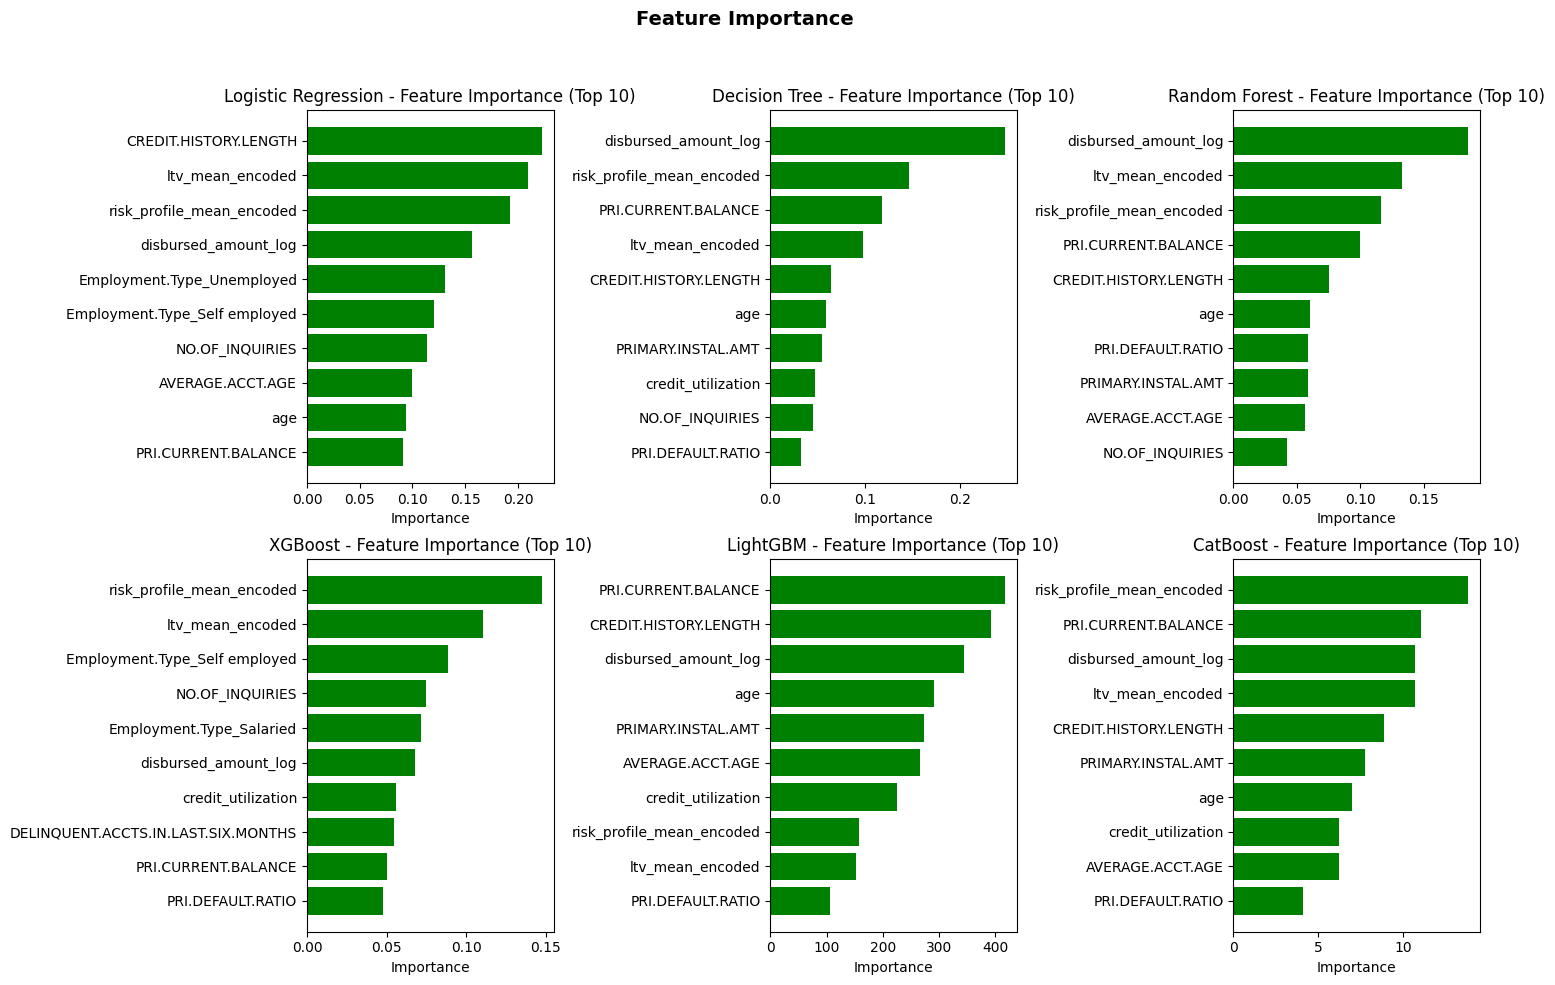

In [15]:
# Visualize feature importance
def plot_feature_importance(feature_importance_results, top_n=10):
    '''
    Plot feature importance for each model.

    Args:
        feature_importance_results: Dictionary containing feature importance for each model
        top_n: Number of top features to plot

    Returns:
        None
    '''
    n_models = len(feature_importance_results)

    if n_models == 0:
        print("No feature importance results to plot")
        return
    
    # Calculate subplot dimensions
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    # Create a figure with subplots for each model
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle('Feature Importance', fontsize=14, fontweight='bold')
    
    # Flatten axes for easier indexing
    axs = np.array(axs).flatten()

    # Plot feature importance for each model
    for (model_name, feature_importance), ax in zip(feature_importance_results.items(), axs):
        # Sort features by importance
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

        # Get top N features
        top_features = sorted_features[:top_n]

        # Plot
        features, values = zip(*top_features)
        ax.barh(range(len(features)), values, color='green')
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels(features)
        ax.set_title(f'{model_name} - Feature Importance (Top {top_n})')
        ax.set_xlabel('Importance')

        # Invert y-axis
        ax.invert_yaxis()

    # Hide unused subplots
    for idx in range(len(feature_importance_results), len(axs)):
        axs[idx].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
# Plot feature importance
plot_feature_importance(feature_importance_results)

### 2.6 Plot Confusion Matrix

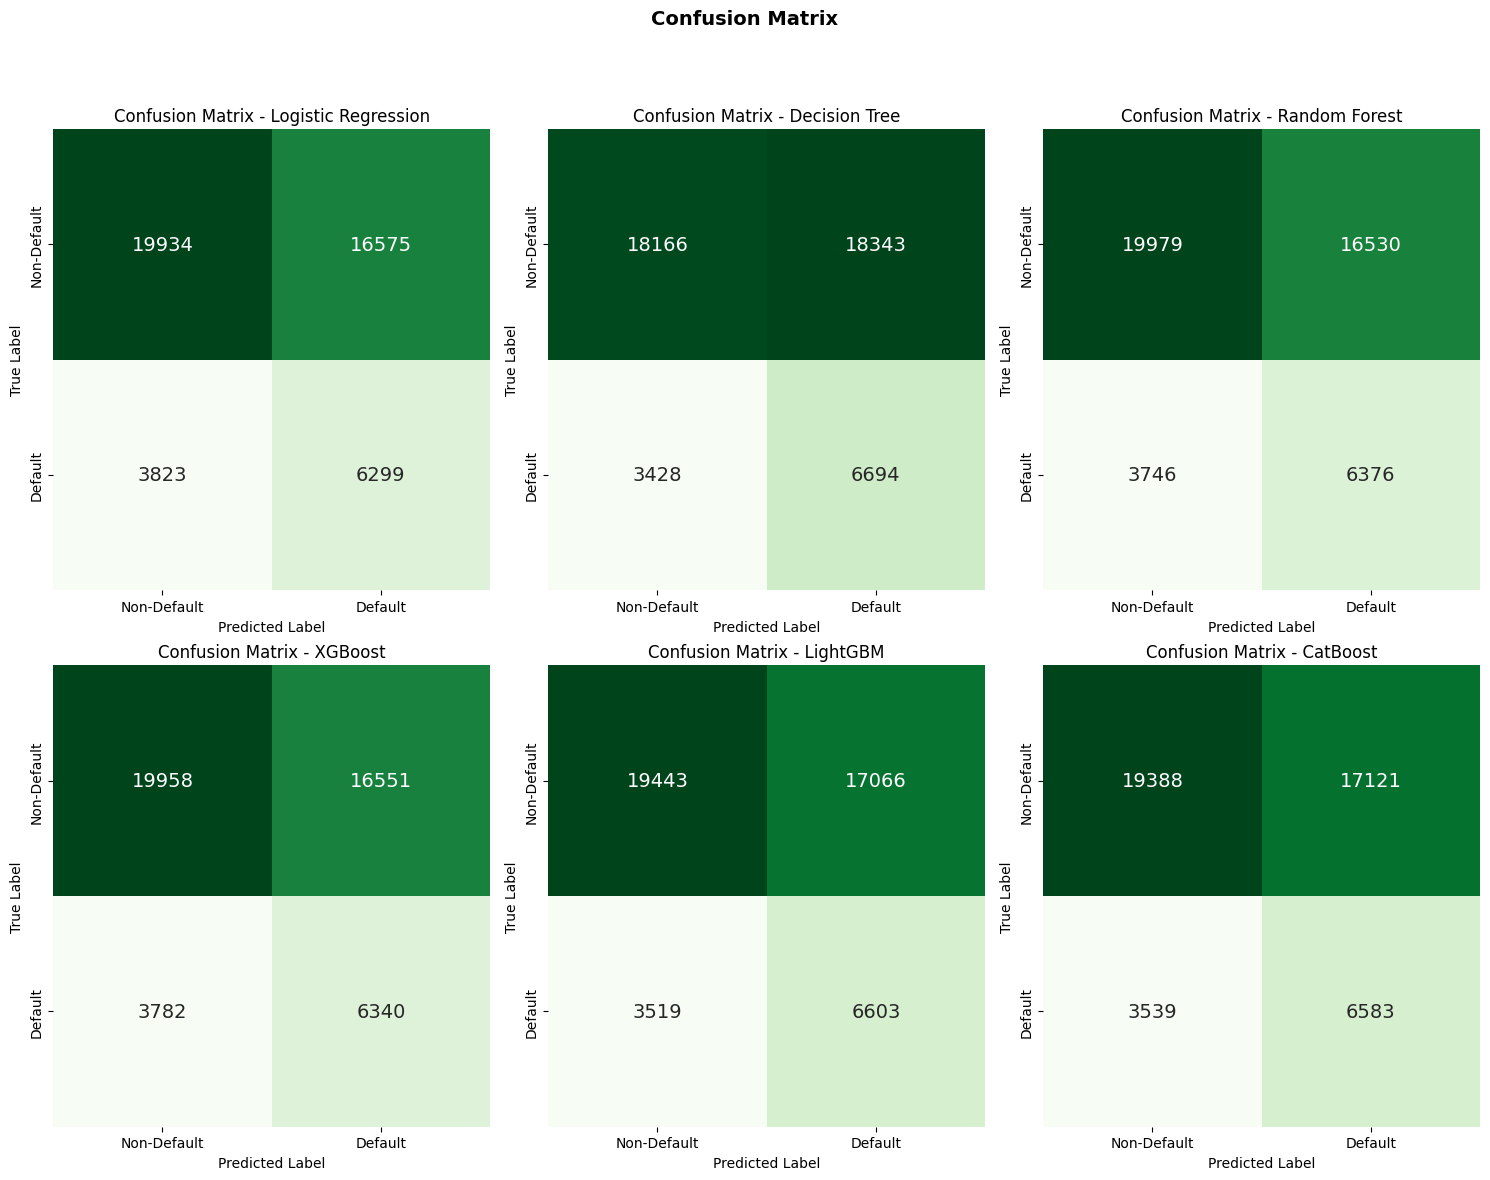

In [16]:
def plot_confusion_matrix(models_dict, X_test, y_test, figsize=(15, 12)):
    '''
    Plot confusion matrix for each model.

    Args:
        models_dict: Dictionary of model names and model objects
        X_test, y_test: Testing data
        figsize: Figure size
    '''
    n_models = len(models_dict)

    if n_models == 0:
        print("No models to plot")
        return
    
    # Calculate subplot dimensions
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols

    # Create a figure with subplots for each model
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Confusion Matrix', fontsize=14, fontweight='bold')

    # Flatten axes for easier indexing
    axs = np.array(axs).flatten()

    # Plot confusion matrix for each model
    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= len(axs):
            break

        # Get predictions
        y_pred = model.predict(X_test)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, annot_kws={'size': 14}, ax=axs[idx])

        # Add labels and title
        axs[idx].set_title(f'Confusion Matrix - {name}')
        axs[idx].set_xlabel('Predicted Label')
        axs[idx].set_ylabel('True Label')

        # Set custom labels for the classes
        axs[idx].set_xticklabels(['Non-Default', 'Default'])
        axs[idx].set_yticklabels(['Non-Default', 'Default'])

    # Hide unused subplots
    for idx in range(len(models_dict), len(axs)):
        axs[idx].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(models, X_test, y_test)
    

## 3) Hyperparameter Tuning

### 3.1 Define Parameter Grids

In [17]:
def get_param_grids():
    '''
    Define parameter grids for different models.
    '''
    param_grids = {
        'Logistic Regression': {
            'C': np.logspace(-2, 1, 20),
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'solver': ['liblinear', 'saga', 'sag'],
            'max_iter': np.arange(100, 1000, 100)
        },
        'Decision Tree': {
            'max_depth': np.arange(2, 20, 2),
            'min_samples_split': np.arange(2, 20, 2),
            'min_samples_leaf': np.arange(1, 10, 1),
            'max_features': ['sqrt', 'log2', None],
            'criterion': ['gini', 'entropy', 'log_loss']
        },
        'Random Forest': {
            'n_estimators': np.arange(100, 1000, 100),
            'max_depth': [None] + list(np.arange(2, 20, 2)),
            'min_samples_split': np.arange(2, 20, 2),
            'min_samples_leaf': np.arange(1, 10, 1),
            'max_features': ['sqrt', 'log2', None],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        'XGBoost': {
            'n_estimators': np.arange(100, 1000, 100),
            'learning_rate': np.logspace(-4, 0, 20),
            'max_depth': np.arange(2, 20, 2),
            'subsample': np.arange(0.5, 1, 0.1),
            'colsample_bytree': np.arange(0.5, 1, 0.1),
            'gamma': np.logspace(-4, 4, 20),
            'lambda': np.logspace(-4, 4, 20),
            'alpha': np.logspace(-4, 4, 20)
        },
        'LightGBM': {
            'n_estimators': np.arange(100, 1000, 100),
            'learning_rate': np.logspace(-4, 0, 20),
            'max_depth': np.arange(2, 20, 2),
            'subsample': np.arange(0.5, 1, 0.1),
            'colsample_bytree': np.arange(0.5, 1, 0.1),
            'reg_alpha': np.logspace(-4, 4, 20),
            'reg_lambda': np.logspace(-4, 4, 20)
        },
        'CatBoost': {
            'iterations': np.arange(100, 1000, 100),
            'learning_rate': np.logspace(-4, 0, 20),
            'depth': np.arange(2, 16, 2),
            'l2_leaf_reg': np.arange(1, 10, 1),
        }
    }
    return param_grids

from sklearn.base import clone

def optimize_model(model, model_name, X_train, y_train, n_iter=20, cv=5, scoring='roc_auc', random_state=42):
    '''
    Optimize a single model using RandomizedSearchCV with StratifiedKFold

    Args:
        model: The model to optimize.
        model_name: The name of the model.
        X_train, y_train: Training data.
        n_iter: The number of iterations.
        cv: The number of cross-validation folds.
        scoring: The scoring metric.

    Returns:
        The optimized model.
    '''
    param_grids = get_param_grids()

    # Get parameter grid for this model
    param_grid = param_grids.get(model_name)
    if param_grid is None:
        print(f"No parameter grid defined for {model_name}. Using default model.")
        return model
    
    # Define cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv_strategy,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )

    # Perform the search
    print(f"Optimizing {model_name} with RandomizedSearchCV...")
    search.fit(X_train, y_train)

    print(f"Best parameters for {model_name}: {search.best_params_}")
    print(f"Best ROC AUC score: {search.best_score_:.4f}")

    # Create a fresh instance of the model with best parameters
    if model_name == 'CatBoost':
        best_model = clone(model).set_params(**search.best_params_, verbose=False)
    elif model_name == 'LightGBM':
        best_model = clone(model).set_params(**search.best_params_, verbose=-1)
    else:
        best_model = clone(model).set_params(**search.best_params_)

    return best_model

### 3.2 Enhanced Training Function with Hyperparameter Tuning

In [18]:
def train_and_evaluate_tuned_models(models_dict, X_train, y_train, X_test, y_test,
                                    evaluate_model, feature_names=None, hyperparams_tuning=True,
                                    n_iter=20, cv=5, random_state=42):
    '''
    Train and evaluate multiple models with tuned hyperparameters using RandomizedSearchCV, and extract feature importance for each model.

    Args:
        models_dict: Dictionary of model names and model objects
        X_train, y_train: Training data
        X_test, y_test: Testing data
        evaluate_model: Function to evaluate model performance
        feature_names: List of feature names (optional)
        hyperparams_tuning: Whether to tune hyperparameters
        n_iter: Number of iterations for RandomizedSearchCV
        cv: Number of cross-validation folds
        random_state: Random state for reproducibility

    Returns:
        results: Dictionary containing results for each model
        feature_importance_results: Dictionary containing feature importance for each model
        optimized_models: Dictionary containing optimized models
    '''
    results = {}
    feature_importance_results = {}
    optimized_models = {}

    print("Training and evaluating models...")
    print("=" * 50)

    for name, model in tqdm(models_dict.items(), desc="Training Models"):
        try:
            print(f"\nTraining {name}...")
            start_time = time.time()

            # Hyperparameter tuning
            if hyperparams_tuning:
                print(f"\nTuning hyperparameters for {name}...")
                model = optimize_model(model, name, X_train, y_train, n_iter=n_iter, cv=cv, random_state=random_state)
                optimized_models[name] = model

            # Special handling for different models
            if name == 'CatBoost':
                model.set_params(verbose=False)
            elif name == 'LightGBM':
                model.set_params(verbose=-1)            # Suppress LightGBM warnings

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            
            # Get proba
            try:
                proba = model.predict_proba(X_test)
                y_pred_proba = proba[:, 1]              # Probability of positive class (i.e., "default" class)
            except Exception as e:
                print(f"Warning: predict_proba failed for {name}: {e}")
                y_pred_proba = y_pred.astype(float)     # Fallback to predicted classes

            # Evaluate the model
            metrics = evaluate_model(y_test, y_pred, y_pred_proba)

            # Extract feature importance
            feature_importance = extract_feature_importance(model, name, feature_names)
            if feature_importance is not None:
                feature_importance_results[name] = feature_importance

            # Store results
            results[name] = metrics

            # Calculate training time
            training_time = time.time() - start_time
            results[name]['Training Time (s)'] = training_time

            print(f"✓ {name} completed in {training_time:.2f} seconds")
            
        except Exception as e:
            print(f"✗ Error training {name}: {str(e)}")
            # Store failed result
            results[name] = {
                # 'Accuracy': 0,
                'Precision': 0,
                'Recall': 0,
                'F1 Score': 0,
                # 'F1 Weighted': 0,
                # 'F1 Macro': 0,
                'ROC AUC': 0,
                'PR AUC': 0,
                'Log Loss': float('inf'),
                'Training Time (s)': 0,
                'Status': 'Failed'
            }
            continue
    
    print("\n" + "=" * 50)
    print("Training completed!")
    
    return results, feature_importance_results, optimized_models


### 3.3 Cross-Validation with StratifiedKFold

In [19]:
from sklearn.base import clone

def cross_validation(models_dict, X_train, y_train, n_splits=5, random_state=42):
    '''
    Perform cross-validation on all models using StratifiedKFold.

    Args:
        models_dict: Dictionary of model names and model objects
        X_train, y_train: Training data
        n_splits: Number of cross-validation splits
        random_state: Random state for reproducibility

    Returns:
        cv_results: Dictionary containing cross-validation results for each model
    '''
    # Convert to numpy arrays if needed
    X_train_arr = X_train.values if hasattr(X_train, 'values') else X_train
    y_train_arr = y_train.values if hasattr(y_train, 'values') else y_train

    cv_results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    print("Performing cross-validation...")
    print("=" * 50)

    for name, model in tqdm(models_dict.items(), desc="Cross-validating Models"):
        try:
            print(f"\nCross-validating {name}...")
            
            # Store metrics for each fold
            fold_metrics = {
                'ROC AUC': [],
                'PR AUC': [],
                'Recall': [],
                'Precision': [],
                'F1 Score': [],
                'Log Loss': []
            }

            # Iterate over each fold
            for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_arr, y_train_arr)):
                # Split data
                X_fold_train, X_fold_val = X_train_arr[train_idx], X_train_arr[val_idx]
                y_fold_train, y_fold_val = y_train_arr[train_idx], y_train_arr[val_idx]

                # Special handling for different models
                if name == 'CatBoost':
                    model_copy = clone(model).set_params(verbose=False)
                elif name == 'LightGBM':
                    model_copy = clone(model).set_params(verbose=-1)
                else:
                    model_copy = clone(model)

                # Train the model
                model_copy.fit(X_fold_train, y_fold_train)

                # Make predictions
                y_pred = model_copy.predict(X_fold_val)

                # Get proba
                try:
                    proba = model_copy.predict_proba(X_fold_val)
                    y_pred_proba = proba[:, 1]              # Probability of positive class (i.e., "default" class)
                except Exception as e:
                    print(f"Warning: predict_proba failed for {name}: {e}")
                    y_pred_proba = y_pred.astype(float)     # Fallback to predicted classes

                # Calculate metrics
                fold_metrics['ROC AUC'].append(roc_auc_score(y_fold_val, y_pred_proba))
                fold_metrics['PR AUC'].append(average_precision_score(y_fold_val, y_pred_proba))
                fold_metrics['Recall'].append(recall_score(y_fold_val, y_pred))
                fold_metrics['Precision'].append(precision_score(y_fold_val, y_pred))
                fold_metrics['F1 Score'].append(f1_score(y_fold_val, y_pred))
                fold_metrics['Log Loss'].append(log_loss(y_fold_val, y_pred_proba))

                print(f"Fold {fold + 1}/{n_splits} completed")

            # Calculate mean and std for each metric
            cv_results[name] = {
                metric: {
                    'mean': np.mean(scores),
                    'std': np.std(scores)
                }
                for metric, scores in fold_metrics.items()
            }

            print(f"✓ {name} CV completed")
            print(f"  ROC AUC: {cv_results[name]['ROC AUC']['mean']:.4f} ± {cv_results[name]['ROC AUC']['std']:.4f}")
            print(f"  PR AUC: {cv_results[name]['PR AUC']['mean']:.4f} ± {cv_results[name]['PR AUC']['std']:.4f}")
            print(f"  Recall: {cv_results[name]['Recall']['mean']:.4f} ± {cv_results[name]['Recall']['std']:.4f}")
            print(f"  Precision: {cv_results[name]['Precision']['mean']:.4f} ± {cv_results[name]['Precision']['std']:.4f}")
            print(f"  F1 Score: {cv_results[name]['F1 Score']['mean']:.4f} ± {cv_results[name]['F1 Score']['std']:.4f}")
            print(f"  Log Loss: {cv_results[name]['Log Loss']['mean']:.4f} ± {cv_results[name]['Log Loss']['std']:.4f}")
            

        except Exception as e:
            print(f"✗ Error cross-validating {name}: {str(e)}")
            cv_results[name] = {
                metric: {
                    'mean': 0,
                    'std': 0
                }
                for metric in ['ROC AUC', 'PR AUC', 'Recall', 'Precision', 'F1 Score', 'Log Loss']
            }

    print("\n" + "=" * 50)
    print("Cross-validation completed!")

    return cv_results

### 3.4 Display Cross-Validation Results

In [20]:
def display_cv_results(cv_results):
    '''
    Display cross-validation results for each model in a formatted DataFrame.

    '''
    # Prepare DataFrame
    data = []
    for model_name, metrics in cv_results.items():
        row = {'Model': model_name}
        for metric, values in metrics.items():
            row[f"{metric} (Mean)"] = values['mean']
            row[f"{metric} (Std)"] = values['std']
        data.append(row)

    # Create DataFrame
    cv_df = pd.DataFrame(data)

    # Set index and sort by PR AUC
    cv_df = cv_df.set_index('Model').sort_values('ROC AUC (Mean)', ascending=False)

    # Format for better display
    for col in cv_df.columns:
        if 'Mean' in col:
            cv_df[col] = cv_df[col].map(lambda x: f"{x:.4f}")
        elif 'Std' in col:
            cv_df[col] = cv_df[col].map(lambda x: f"{x:.4f}")

    # Display DataFrame
    print("\nCross-validation Results Ranking (by ROC AUC):")
    print("=" * 80)
    print(cv_df)

    # Create a more compact visualization
    plt.figure(figsize=(12, 6))

    # Extract mean and std for ROC AUC
    models = list(cv_results.keys())
    means = [cv_results[model]['ROC AUC']['mean'] for model in models]
    stds = [cv_results[model]['ROC AUC']['std'] for model in models]

    # Sort by mean ROC AUC
    sorted_indices = np.argsort(means)[::-1]
    sorted_models = [models[i] for i in sorted_indices]
    sorted_means = [means[i] for i in sorted_indices]
    sorted_stds = [stds[i] for i in sorted_indices]

    # Plot
    plt.barh(
        range(len(sorted_models)), sorted_means, xerr=sorted_stds,
        capsize=5, color='skyblue', alpha=0.7, edgecolor='black'
    )
    plt.yticks(range(len(sorted_models)), sorted_models)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.xlabel('ROC AUC Score')
    plt.title('Cross-validation ROC AUC Scores (Mean ± Std)')
    plt.tight_layout()
    plt.show()

    return cv_df

### 3.5 Plot ROC Curves

In [21]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curves for Top N Models
def plot_roc_curves(models_dict, X_test, y_test, figsize=(15, 12)):
    '''
    Plot ROC curves for Top N models.

    Args:
        models_dict: Dictionary of model names and model objects
        X_test, y_test: Testing data
        figsize: Figure size
    '''
    plt.figure(figsize=figsize)

    # Plot ROC curve for for each model in the same plot
    for name, model in models_dict.items():
        try:
            # Get prediction probabilities
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

        except Exception as e:
            print(f"Warning: Could not plot ROC curve for {name}: {e}")
            
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Add labels and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curves (Top N Models)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

### 3.6 Generate Classification Report

In [22]:
# Generate Classification Report for Best Model
def generate_classification_report(model, X_test, y_test, model_name='Best Model'):
    '''
    Generate a classification report for the best model.

    Args:
        model: Trained model.
        X_test, y_test: Test data.
        model_name: Name of the model.
    '''
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Print classification report
    report = classification_report(y_test, y_pred, target_names=['Non-Default', 'Default'])
    print(f"\nClassification Report for {model_name}:")
    print("=" * 60)
    print(report)

    return

## 4) Main Execution

Performing cross-validation...


Cross-validating Models:   0%|          | 0/6 [00:00<?, ?it/s]


Cross-validating Logistic Regression...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed


Cross-validating Models:  17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]

Fold 5/5 completed
✓ Logistic Regression CV completed
  ROC AUC: 0.6220 ± 0.0031
  PR AUC: 0.2991 ± 0.0041
  Recall: 0.6284 ± 0.0049
  Precision: 0.2788 ± 0.0015
  F1 Score: 0.3862 ± 0.0023
  Log Loss: 0.6702 ± 0.0009

Cross-validating Decision Tree...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed


Cross-validating Models:  33%|███▎      | 2/6 [00:03<00:06,  1.61s/it]

Fold 5/5 completed
✓ Decision Tree CV completed
  ROC AUC: 0.6081 ± 0.0012
  PR AUC: 0.2804 ± 0.0014
  Recall: 0.6358 ± 0.0103
  Precision: 0.2726 ± 0.0025
  F1 Score: 0.3816 ± 0.0019
  Log Loss: 0.8420 ± 0.0169

Cross-validating Random Forest...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed


Cross-validating Models:  50%|█████     | 3/6 [00:45<01:01, 20.39s/it]

Fold 5/5 completed
✓ Random Forest CV completed
  ROC AUC: 0.6292 ± 0.0036
  PR AUC: 0.3063 ± 0.0042
  Recall: 0.6330 ± 0.0074
  Precision: 0.2820 ± 0.0015
  F1 Score: 0.3901 ± 0.0026
  Log Loss: 0.6549 ± 0.0007

Cross-validating XGBoost...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed


Cross-validating Models:  67%|██████▋   | 4/6 [00:47<00:25, 12.98s/it]

Fold 5/5 completed
✓ XGBoost CV completed
  ROC AUC: 0.6264 ± 0.0046
  PR AUC: 0.3021 ± 0.0044
  Recall: 0.6331 ± 0.0080
  Precision: 0.2821 ± 0.0024
  F1 Score: 0.3903 ± 0.0038
  Log Loss: 0.6558 ± 0.0014

Cross-validating LightGBM...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed


Cross-validating Models:  83%|████████▎ | 5/6 [00:51<00:09,  9.91s/it]

Fold 5/5 completed
✓ LightGBM CV completed
  ROC AUC: 0.6334 ± 0.0036
  PR AUC: 0.3090 ± 0.0041
  Recall: 0.6562 ± 0.0067
  Precision: 0.2833 ± 0.0014
  F1 Score: 0.3957 ± 0.0024
  Log Loss: 0.6597 ± 0.0008

Cross-validating CatBoost...
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed


Cross-validating Models: 100%|██████████| 6/6 [00:57<00:00,  9.51s/it]

Fold 5/5 completed
✓ CatBoost CV completed
  ROC AUC: 0.6318 ± 0.0035
  PR AUC: 0.3078 ± 0.0036
  Recall: 0.6544 ± 0.0080
  Precision: 0.2828 ± 0.0013
  F1 Score: 0.3949 ± 0.0027
  Log Loss: 0.6608 ± 0.0008

Cross-validation completed!

Cross-validation Results Ranking (by ROC AUC):
                    ROC AUC (Mean) ROC AUC (Std) PR AUC (Mean) PR AUC (Std)  \
Model                                                                         
LightGBM                    0.6334        0.0036        0.3090       0.0041   
CatBoost                    0.6318        0.0035        0.3078       0.0036   
Random Forest               0.6292        0.0036        0.3063       0.0042   
XGBoost                     0.6264        0.0046        0.3021       0.0044   
Logistic Regression         0.6220        0.0031        0.2991       0.0041   
Decision Tree               0.6081        0.0012        0.2804       0.0014   

                    Recall (Mean) Recall (Std) Precision (Mean)  \
Model           

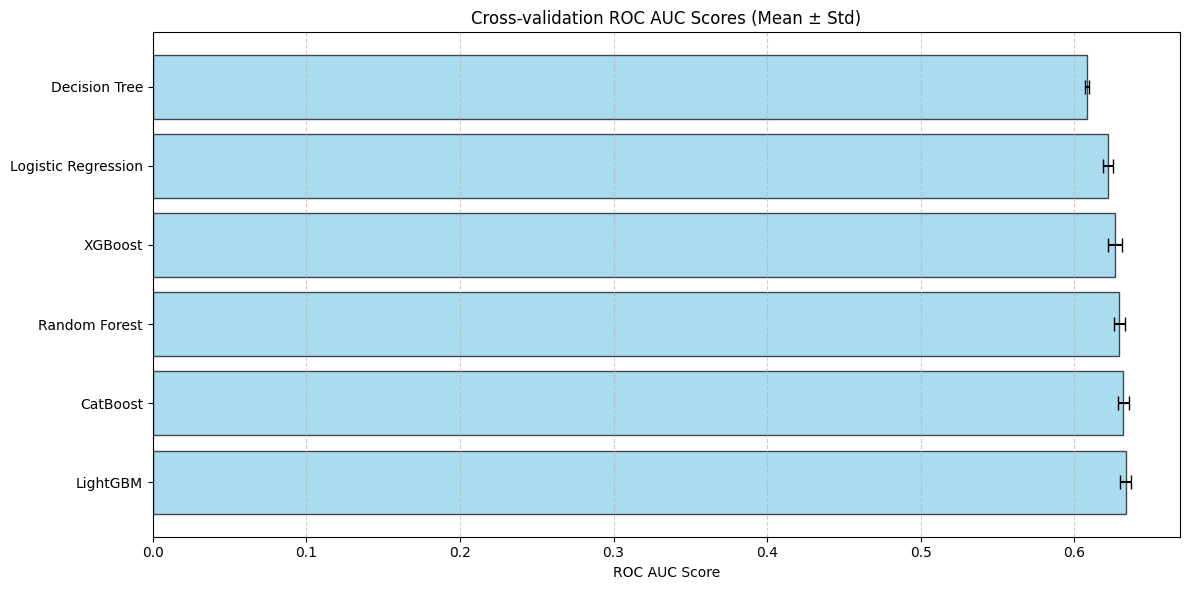


 Selected top 4 models for hyperparameter tuning:
  - LightGBM
  - CatBoost
  - Random Forest
  - XGBoost
Training and evaluating models...


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]


Training LightGBM...

Tuning hyperparameters for LightGBM...
Optimizing LightGBM with RandomizedSearchCV...
Best parameters for LightGBM: {'subsample': np.float64(0.7), 'reg_lambda': np.float64(29.763514416313132), 'reg_alpha': np.float64(11.288378916846883), 'n_estimators': np.int64(300), 'max_depth': np.int64(14), 'learning_rate': np.float64(0.0206913808111479), 'colsample_bytree': np.float64(0.8999999999999999)}
Best ROC AUC score: 0.6353


Training Models:  25%|██▌       | 1/4 [03:29<10:29, 209.76s/it]

✓ LightGBM completed in 209.76 seconds

Training CatBoost...

Tuning hyperparameters for CatBoost...
Optimizing CatBoost with RandomizedSearchCV...
Best parameters for CatBoost: {'learning_rate': np.float64(0.05455594781168514), 'l2_leaf_reg': np.int64(5), 'iterations': np.int64(500), 'depth': np.int64(4)}
Best ROC AUC score: 0.6345


Training Models:  50%|█████     | 2/4 [14:31<15:51, 475.76s/it]

✓ CatBoost completed in 661.96 seconds

Training Random Forest...

Tuning hyperparameters for Random Forest...
Optimizing Random Forest with RandomizedSearchCV...
Best parameters for Random Forest: {'n_estimators': np.int64(800), 'min_samples_split': np.int64(6), 'min_samples_leaf': np.int64(5), 'max_features': 'sqrt', 'max_depth': np.int64(10), 'class_weight': 'balanced'}
Best ROC AUC score: 0.6301


Training Models:  75%|███████▌  | 3/4 [29:43<11:14, 674.77s/it]

✓ Random Forest completed in 911.58 seconds

Training XGBoost...

Tuning hyperparameters for XGBoost...
Optimizing XGBoost with RandomizedSearchCV...
Best parameters for XGBoost: {'subsample': np.float64(0.7999999999999999), 'n_estimators': np.int64(500), 'max_depth': np.int64(16), 'learning_rate': np.float64(0.05455594781168514), 'lambda': np.float64(78.47599703514607), 'gamma': np.float64(0.615848211066026), 'colsample_bytree': np.float64(0.5), 'alpha': np.float64(206.913808111479)}
Best ROC AUC score: 0.6326


Training Models: 100%|██████████| 4/4 [30:26<00:00, 456.51s/it]

✓ XGBoost completed in 42.74 seconds

Training completed!
Model Performance Ranking (by ROC AUC):
               Precision  Recall  F1 Score  ROC AUC  PR AUC  Log Loss  \
LightGBM          0.2786  0.6564    0.3912   0.6296  0.3052    0.6632   
CatBoost          0.2798  0.6529    0.3917   0.6292  0.3044    0.6647   
XGBoost           0.2790  0.6480    0.3900   0.6283  0.3019    0.6657   
Random Forest     0.2784  0.6339    0.3869   0.6254  0.3014    0.6583   

               Training Time (s)  
LightGBM              209.761754  
CatBoost              661.963703  
XGBoost                42.740392  
Random Forest         911.583377  


,Precision,Recall,F1 Score,ROC AUC,PR AUC,Log Loss,Training Time (s)
LightGBM,0.2786,0.6564,0.3912,0.6296,0.3052,0.6632,209.761754
CatBoost,0.2798,0.6529,0.3917,0.6292,0.3044,0.6647,661.963703
XGBoost,0.2790,0.6480,0.3900,0.6283,0.3019,0.6657,42.740392
Random Forest,0.2784,0.6339,0.3869,0.6254,0.3014,0.6583,911.583377


In [23]:
# Step 1: Cross-validate all models to identify top performers
cv_results = cross_validation(models, X_train, y_train, n_splits=5, random_state=42)

# Display cross-validation results
cv_df = display_cv_results(cv_results)

# Step 2: Identify top N models for hyperparameter tuning
top_n = 4
top_models = {}
for model_name in cv_df.index[:top_n]:
    top_models[model_name] = models[model_name]

print(f"\n Selected top {top_n} models for hyperparameter tuning:")
for model_name in top_models.keys():
    print(f"  - {model_name}")

# Step 3: Train and evaluate top N models with tuned hyperparameters
results, feature_importance_results, optimized_models = train_and_evaluate_tuned_models(
    top_models, X_train, y_train, X_test, y_test,
    evaluate_model, feature_names=feature_names, hyperparams_tuning=True,
    n_iter=20, cv=5, random_state=42
)

# Step 4: Display final results
display_results(results)

ROC Curves for Top Models after Hyperparameter Tuning:


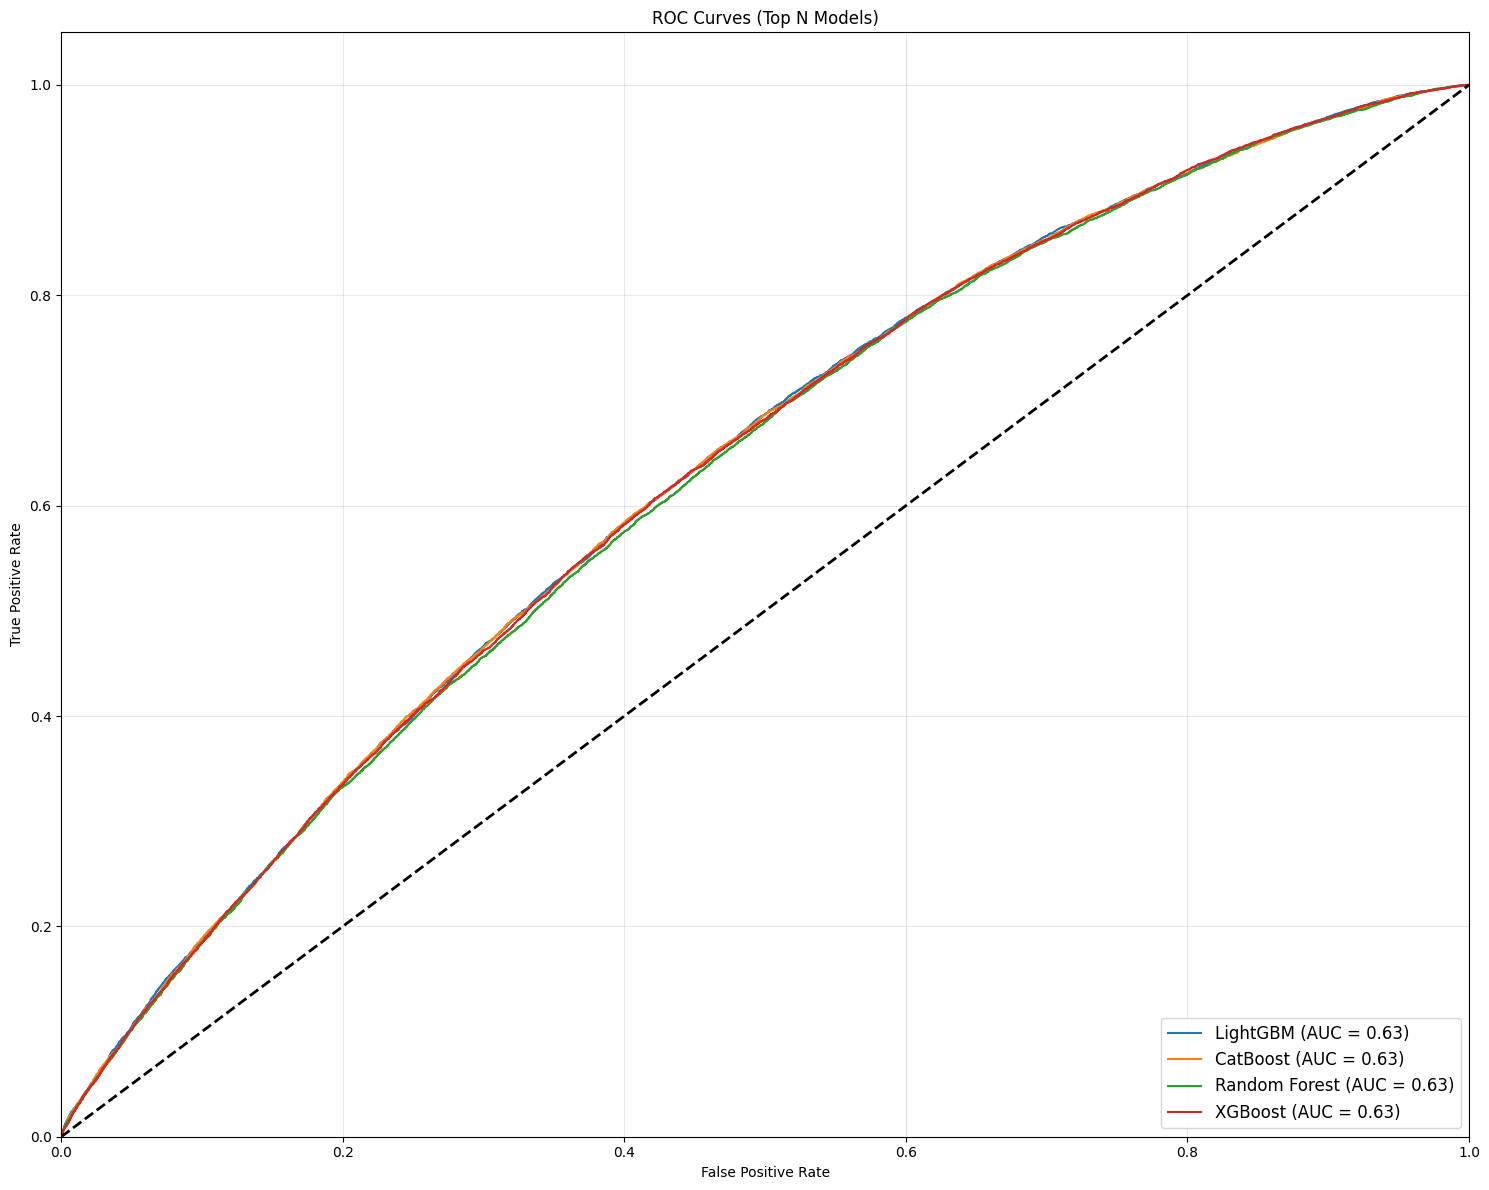

In [24]:
# Step 5: Visualize ROC Curves
print("ROC Curves for Top Models after Hyperparameter Tuning:")
plot_roc_curves(optimized_models, X_test, y_test)

Feature Importance for Top Models after Hyperparameter Tuning:


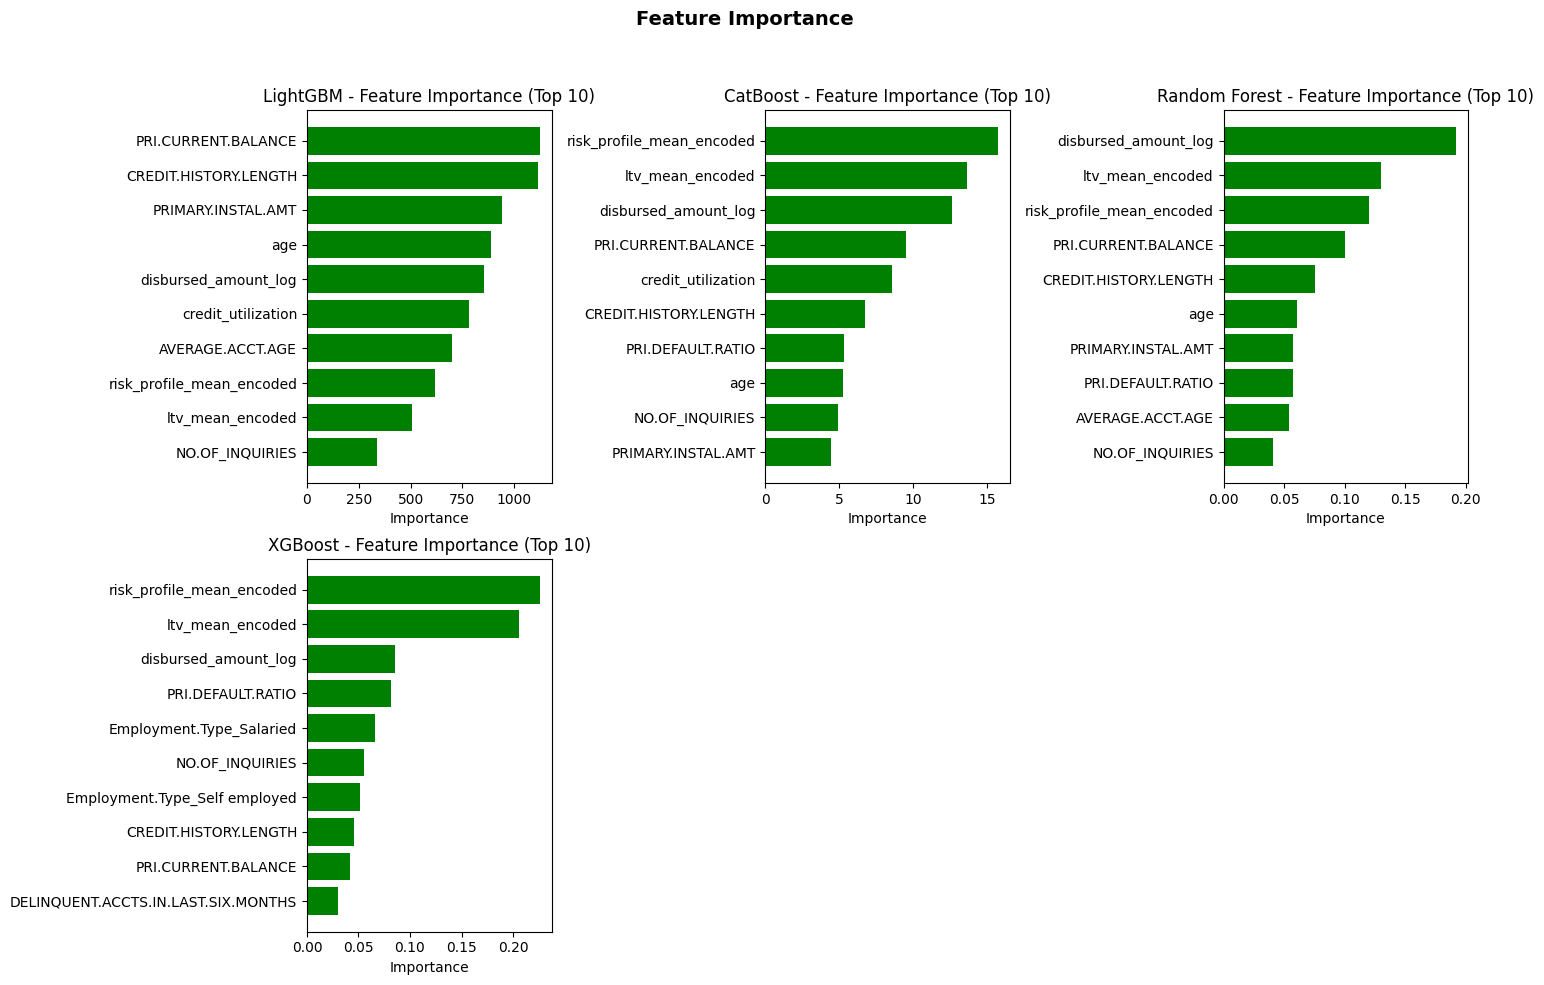

In [25]:
# Step 6: Visualize feature importance
print("Feature Importance for Top Models after Hyperparameter Tuning:")
plot_feature_importance(feature_importance_results)

In [26]:
# Step 6: Select best model
best_model_name = max(results.items(), key=lambda x: x[1]['ROC AUC'])[0]
best_model = optimized_models[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"Best model parameters: {best_model.get_params()}")
generate_classification_report(best_model, X_test, y_test, model_name=best_model_name)


Best model: LightGBM
Best model parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': np.float64(0.8999999999999999), 'importance_type': 'split', 'learning_rate': np.float64(0.0206913808111479), 'max_depth': np.int64(14), 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(300), 'n_jobs': None, 'num_leaves': 31, 'objective': 'binary', 'random_state': 42, 'reg_alpha': np.float64(11.288378916846883), 'reg_lambda': np.float64(29.763514416313132), 'subsample': np.float64(0.7), 'subsample_for_bin': 200000, 'subsample_freq': 0, 'scale_pos_weight': 3.6067573908962927, 'metric': 'auc', 'verbose': -1}

Classification Report for LightGBM:
              precision    recall  f1-score   support

 Non-Default       0.85      0.53      0.65     36509
     Default       0.28      0.66      0.39     10122

    accuracy                           0.56     46631
   macro avg       0.56      0.59      0.52     46631
weighted avg    

## 5) Save the Best Model

In [27]:
import os
import pickle
import datetime

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the best model
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', f'best_model_{best_model_name}_{current_time}.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Model saved to: {model_path}")

Model saved to: models/best_model_LightGBM_20250711_093441.pkl
